### Processing

In [1]:
import os
import pandas as pd

def compile_csv_folder(folder_path):
    """
    Reads all CSV files in the given folder, drops duplicates, and combines them into a single DataFrame.

    Parameters:
        folder_path (str): The path to the folder containing the CSV files.

    Returns:
        pd.DataFrame: A combined DataFrame with all unique rows from all CSV files.
    """
    all_dataframes = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if not file.lower().endswith('.csv'):
            continue
        try:
            # Exclude unwanted columns
            selected_columns = ['destination', 'direction_code', 'state', 'station_name', 'line.id',
                                'collected_at',  'line.transport_mode',  'scheduled',  'expected', 'direction', 
                                'deviations', 'journey.id', 'journey.state','stop_area.id', 'stop_area.name',
                                'stop_area.type', 'stop_point.id', 'display','stop_point.name', 'line.designation', 
                                'site_id']
            # Now read only the selected columns
            df = pd.read_csv(file_path, usecols=selected_columns, low_memory=False)
            if df['line.id'].apply(lambda x: not str(x).isdigit()).any():
                print(f"⚠️ Warning: Non-integer values found in 'line.id' in file: {file}")

            # Convert strings to datetime objects
            df['scheduled'] = pd.to_datetime(df['scheduled'])
            df['expected'] = pd.to_datetime(df['expected'])
            # Calculate the difference
            df['delay'] = (df['expected'] - df['scheduled']).dt.total_seconds()  # convert the difference to seconds
            # Extract the hour and minute components and store them in separate columns
            df['hour'] = df['scheduled'].dt.hour
            df['minute'] = df['scheduled'].dt.minute
            df['time'] = df['scheduled'].dt.strftime('%H:%M:%S')
            all_dataframes.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        return combined_df
    else:
        print("No files could be read.")
        return pd.DataFrame()

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

df_mon = compile_csv_folder("/Users/y.sota/Downloads/AH2173_public_transport/collected_data/20250505_065322_peak1_mon")
df_tue = compile_csv_folder("/Users/y.sota/Downloads/AH2173_public_transport/collected_data/20250429_065602_peak1_tue_comp")
df_wed = compile_csv_folder("/Users/y.sota/Downloads/AH2173_public_transport/collected_data/20250430_065201_peak1_wed_comp")
df_fri = compile_csv_folder("/Users/y.sota/Downloads/AH2173_public_transport/collected_data/20250502_065442_peak1_fri_comp")

In [3]:
filtered_db = pd.concat([df_mon, df_tue, df_wed, df_fri])
print(filtered_db.shape)
filtered_db["hour"].unique()
filtered_db = filtered_db[filtered_db["hour"].isin([7,8,9])]
print(filtered_db.shape)

(1104308, 25)
(979195, 25)


#### At the departure

/var/folders/pd/dr9kbswj1c3brg3llqmr7q6m0000gn/T/ipykernel_72053/951521732.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_copy, x='line.id', y='delay', palette='Set3')


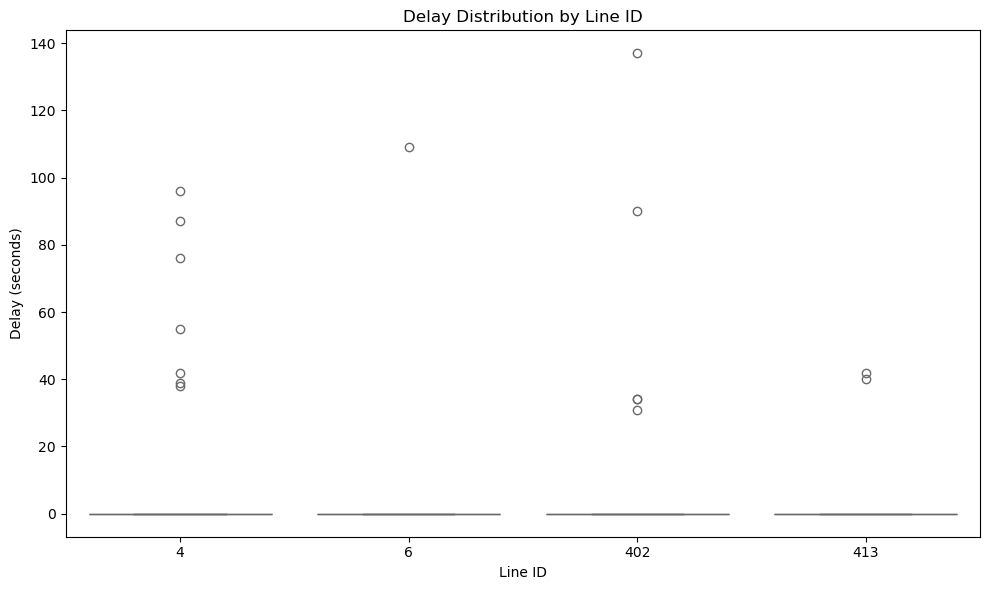

(4, 11)

In [274]:
# Keep only the relevant columns
filtered_db = filtered_db[['destination', 'direction_code', 'state', 'delay', 'station_name', 'line.id',
       'collected_at',  'line.transport_mode',  'scheduled',  'expected', 'direction', 
       'deviations', 'journey.id', 'journey.state', 'stop_area.id', 'stop_area.name',
       'stop_area.type', 'stop_point.id', 'display','stop_point.name', 
       'line.designation', 'site_id',  'hour', 'minute', 'time']]
# Step 0: Filter only specific bus lines
target_ids = [4, 6, 402, 413]
filtered_db = filtered_db.loc[
    (filtered_db["line.transport_mode"] == "BUS") &
    (filtered_db["line.id"].isin(target_ids))
]
filtered_db['collected_at'] = pd.to_datetime(filtered_db['collected_at'])

# Step 1: Define the target stations for analysis
target_stations = ['Radiohuset', 'Nacka Forum, stadshuset', 'Gullmarsplan',
       'Karolinska institutet Biomedicum', 'Slussen','Ropsten']

# Step 2: Keep only the rows from those stations
filtered_db = filtered_db[filtered_db['station_name'].isin(target_stations)]

# Step 3: Group by journey.id and keep the row with the maximum delay for each journey
filtered_copy = filtered_db.copy()  # Prevent overwriting the original
filtered_copy = filtered_copy.loc[
    filtered_copy.groupby('journey.id')['delay'].idxmax()
].reset_index(drop=True)

# Step 4: Generate descriptive statistics by line.id
summary = filtered_copy.groupby('line.id')['delay'].describe().reset_index()

# Step 5: Count how many delays exceeded 60 seconds for each line
delay_over_60 = filtered_copy[filtered_copy['delay'].abs() > 60].groupby('line.id')['delay'].count().reset_index()
delay_over_60 = delay_over_60.rename(columns={'delay': 'delay_over_60_count'})

# Step 6: Merge the count of delays > 60 seconds into the summary
summary = pd.merge(summary, delay_over_60, on='line.id', how='left')
summary['delay_over_60_count'] = summary['delay_over_60_count'].fillna(0).astype(int)

# Step 7: Calculate punctuality as the percentage of journeys with delay ≤ 60 seconds
summary['punctuality(%)'] = 100 * (1 - (summary['delay_over_60_count'] / summary['count']))
summary['punctuality(%)'] = summary['punctuality(%)'].round(2)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_copy, x='line.id', y='delay', palette='Set3')

plt.title('Delay Distribution by Line ID')
plt.xlabel('Line ID')
plt.ylabel('Delay (seconds)')
plt.tight_layout()
plt.savefig('boxplot_all_dep.png', dpi=300)  # ← Save here
plt.show()


summary

#### At the middle bus stop

/var/folders/pd/dr9kbswj1c3brg3llqmr7q6m0000gn/T/ipykernel_72053/1414241659.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_copy, x='line.id', y='delay', palette='Set3')


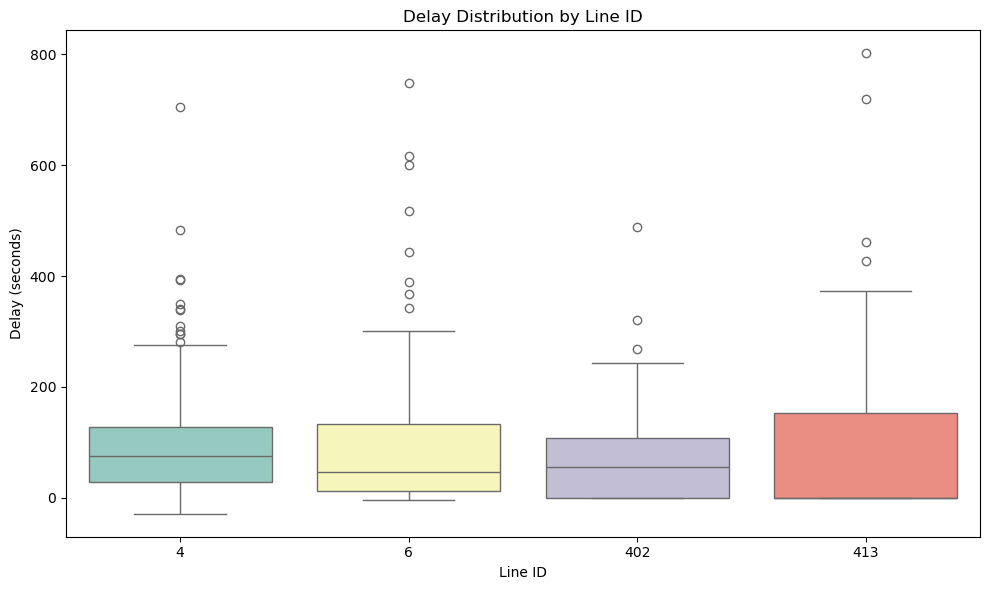

,line.id,count,mean,std,min,25%,50%,75%,max,delay_over_60_count,punctuality(%)
0,4,190.0,97.800000,98.745260,-29.0,28.0,75.0,128.00,706.0,111,41.58
1,6,138.0,94.746377,128.975302,-5.0,12.5,47.0,132.50,749.0,62,55.07
2,402,98.0,73.408163,89.820995,0.0,0.0,54.5,107.25,489.0,46,53.06
3,413,44.0,104.636364,191.869516,0.0,0.0,0.0,152.50,802.0,15,65.91


In [304]:
# Keep only the relevant columns
filtered_db = filtered_db[['destination', 'direction_code', 'state', 'delay', 'station_name', 'line.id',
       'collected_at',  'line.transport_mode',  'scheduled',  'expected', 'direction', 
       'deviations', 'journey.id', 'journey.state', 'stop_area.id', 'stop_area.name',
       'stop_area.type', 'stop_point.id', 'display','stop_point.name', 
       'line.designation', 'site_id',  'hour', 'minute', 'time']]

# Step 0: Filter only specific bus lines
target_ids = [4, 6, 402, 413]
filtered_db = filtered_db.loc[
    (filtered_db["line.transport_mode"] == "BUS") &
    (filtered_db["line.id"].isin(target_ids))
]
filtered_db['collected_at'] = pd.to_datetime(filtered_db['collected_at'])

# Step 1: Define the target stations for analysis
target_stations = ['Nacka Forum', 'Västerbroplan',
       'Gäddviken', 'Roslagsgatan',"Skurustugan" 
]

# Step 2: Keep only the rows from those stations
filtered_db = filtered_db[filtered_db['station_name'].isin(target_stations)]

# Step 3: Group by journey.id and keep the row with the maximum delay for each journey
filtered_copy = filtered_db.copy()  # Prevent overwriting the original
filtered_copy = filtered_copy.loc[
    filtered_copy.groupby('journey.id')['delay'].idxmax()
].reset_index(drop=True)

# Step 4: Generate descriptive statistics by line.id
summary = filtered_copy.groupby('line.id')['delay'].describe().reset_index()

# Step 5: Count how many delays exceeded 60 seconds for each line
delay_over_60 = filtered_copy[filtered_copy['delay'].abs() > 60].groupby('line.id')['delay'].count().reset_index()
delay_over_60 = delay_over_60.rename(columns={'delay': 'delay_over_60_count'})

# Step 6: Merge the count of delays > 60 seconds into the summary
summary = pd.merge(summary, delay_over_60, on='line.id', how='left')
summary['delay_over_60_count'] = summary['delay_over_60_count'].fillna(0).astype(int)

# Step 7: Calculate punctuality as the percentage of journeys with delay ≤ 60 seconds
summary['punctuality(%)'] = 100 * (1 - (summary['delay_over_60_count'] / summary['count']))
summary['punctuality(%)'] = summary['punctuality(%)'].round(2)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_copy, x='line.id', y='delay', palette='Set3')

plt.title('Delay Distribution by Line ID')
plt.xlabel('Line ID')
plt.ylabel('Delay (seconds)')
plt.tight_layout()
plt.savefig('boxplot_all_mid.png', dpi=300)  # ← Save here
plt.show()


# Final summary
summary

In [280]:
filtered_db["station_name"].unique()

array(['Nacka Forum', 'Västerbroplan', 'Gäddviken', 'Roslagsgatan'],
      dtype=object)

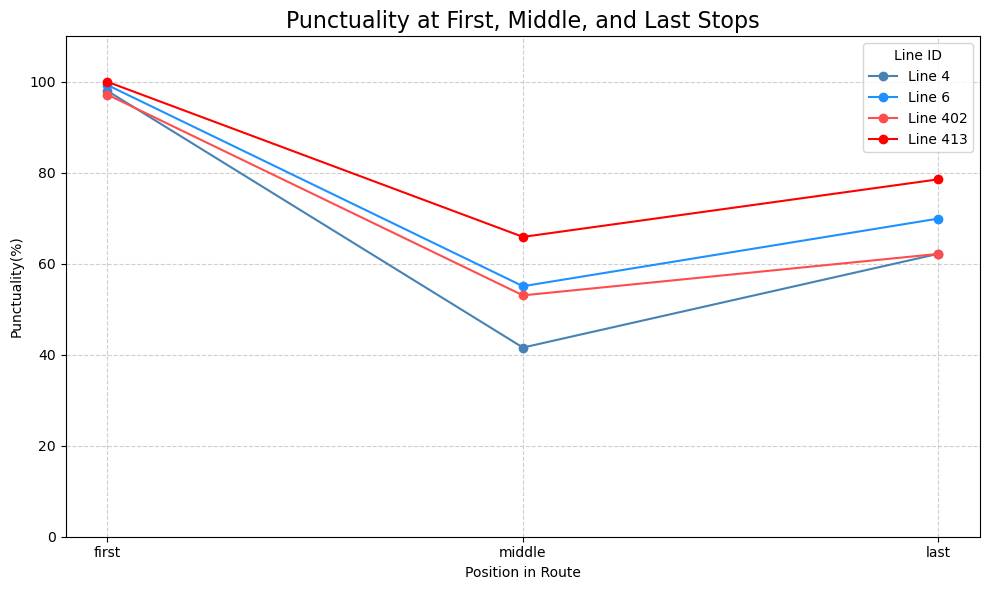

In [322]:
import pandas as pd
import matplotlib.pyplot as plt

# Updated data
df_transition_latest = pd.DataFrame({
    'line.id': [4, 6, 402, 413],
    'first': [98.00, 99.29, 97.18, 100.00],
    'middle': [41.58, 55.07, 53.06, 65.91],
    'last': [62.20, 69.94, 62.18, 78.57]
})

# Set line.id as index
df_transition_latest.set_index('line.id', inplace=True)

# Define color mapping: blue-ish for 4 & 6, red-ish for 402 & 413
color_map = {
    4: 'steelblue',
    6: 'dodgerblue',
    402: '#FF4C4C',   # bright red
    413: '#FF0000'    # pure red
}

# Plot
plt.figure(figsize=(10, 6))
for idx in df_transition_latest.index:
    plt.plot(
        df_transition_latest.columns,
        df_transition_latest.loc[idx],
        marker='o',
        label=f'Line {idx}',
        color=color_map[idx]
    )

plt.title('Punctuality at First, Middle, and Last Stops',fontsize=16)
plt.xlabel('Position in Route')
plt.ylabel('Punctuality(%)')
plt.ylim(0, 110)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Line ID')
plt.tight_layout()
plt.savefig('line_graph_punctuality.png', dpi=300)  # ← Save here
plt.show()

### ADOPTED:Take the dalay at the terminal

In [5]:
# Keep only the relevant columns
filtered_db = filtered_db[['destination', 'direction_code', 'state', 'delay', 'station_name', 'line.id',
       'collected_at',  'line.transport_mode',  'scheduled',  'expected', 'direction', 
       'deviations', 'journey.id', 'journey.state', 'stop_area.id', 'stop_area.name',
       'stop_area.type', 'stop_point.id', 'display','stop_point.name', 
       'line.designation', 'site_id',  'hour', 'minute', 'time']]

# Step 0: Filter only specific bus lines
target_ids = [4, 6, 402, 413]
filtered_db = filtered_db.loc[
    (filtered_db["line.transport_mode"] == "BUS") &
    (filtered_db["line.id"].isin(target_ids))
]
filtered_db['collected_at'] = pd.to_datetime(filtered_db['collected_at'])

# Step 1: Define the target stations for analysis
target_stations = [
    'Skanstull', 'Garnisonen', 'Glasbrukssjön', 'Karolinska sjukhuset Eugeniavägen',
    'Drevergatan', 'Londonviadukten', 'Nacka gymnasium'
]

# Step 2: Keep only the rows from those stations
filtered_db = filtered_db[filtered_db['station_name'].isin(target_stations)]

# Step 3: Group by journey.id and keep the row with the maximum delay for each journey
filtered_copy = filtered_db.copy()  # Prevent overwriting the original
filtered_copy = filtered_copy.loc[
    filtered_copy.groupby('journey.id')['delay'].idxmax()
].reset_index(drop=True)

# Step 4: Generate descriptive statistics by line.id
summary = filtered_copy.groupby('line.id')['delay'].describe().reset_index()

# Step 5: Count how many delays exceeded 60 seconds for each line
delay_over_60 = filtered_copy[filtered_copy['delay'].abs() > 60].groupby('line.id')['delay'].count().reset_index()
delay_over_60 = delay_over_60.rename(columns={'delay': 'delay_over_60_count'})

# Step 6: Merge the count of delays > 60 seconds into the summary
summary = pd.merge(summary, delay_over_60, on='line.id', how='left')
summary['delay_over_60_count'] = summary['delay_over_60_count'].fillna(0).astype(int)

# Step 7: Calculate punctuality as the percentage of journeys with delay ≤ 60 seconds
summary['punctuality(%)'] = 100 * (1 - (summary['delay_over_60_count'] / summary['count']))
summary['punctuality(%)'] = summary['punctuality(%)'].round(2)
summary[['mean', 'std','punctuality(%)']] = summary[['mean',  'std','punctuality(%)']].round(1)
# Final summary
summary
#filtered_copy.shape

,line.id,count,mean,std,min,25%,50%,75%,max,delay_over_60_count,punctuality(%)
0,4,209.0,40.1,111.3,-193.0,0.0,16.0,71.0,835.0,79,62.2
1,6,173.0,45.3,118.8,-160.0,0.0,0.0,60.0,740.0,52,69.9
2,402,119.0,67.8,124.7,-110.0,0.0,23.0,96.0,817.0,45,62.2
3,413,28.0,42.0,105.5,0.0,0.0,0.0,40.5,539.0,6,78.6


In [7]:
import pandas as pd
import numpy as np

# Step 1: Summary statistics by line.id
summary = (
    filtered_copy.groupby('line.id')['delay']
    .agg(['count', 'mean', 'median', 'std'])
    .reset_index()
)

# Step 2: Calculate 95% confidence interval
summary['ci'] = 1.96 * (summary['std'] / np.sqrt(summary['count']))

# Step 3: Count delays > 60 seconds (absolute value)
delay_over_60 = (
    filtered_copy[filtered_copy['delay'].abs() > 60]
    .groupby('line.id')['delay']
    .count()
    .reset_index()
    .rename(columns={'delay': 'delay_over_60_count'})
)

# Step 4: Merge delay_over_60 counts
summary = summary.merge(delay_over_60, on='line.id', how='left')
summary['delay_over_60_count'] = summary['delay_over_60_count'].fillna(0).astype(int)

# Step 5: Calculate punctuality
summary['punctuality(%)'] = 100 * (1 - summary['delay_over_60_count'] / summary['count'])

# Step 6: Round selected columns
summary[['mean', 'median', 'std', 'ci', 'punctuality(%)']] = summary[[
    'mean', 'median', 'std', 'ci', 'punctuality(%)'
]].round(1)

# Step 7: Select desired columns to display
summary_display = summary[['line.id', 'count', 'mean', 'median', 'std', 'ci', 'punctuality(%)']]

# Show the final summary
summary_display

,line.id,count,mean,median,std,ci,punctuality(%)
0,4,209,40.1,16.0,111.3,15.1,62.2
1,6,173,45.3,0.0,118.8,17.7,69.9
2,402,119,67.8,23.0,124.7,22.4,62.2
3,413,28,42.0,0.0,105.5,39.1,78.6


In [9]:
import numpy as np
#Step 1: Update grouping logic with meaningful labels
filtered_copy['group_a'] = filtered_copy['line.id'].map({
    6: 'Shorter Route(6 & 402)',
    402: 'Shorter Route(6 & 402)',
    4: 'Longer Route(4 & 413)',
    413:
    'Longer Route(4 & 413)'
})

filtered_copy['group_b'] = filtered_copy['line.id'].map({
    4: 'Urban(4 & 6)',    
    6: 'Urban(4 & 6)',
    402: 'Suburban(402 & 413)',
    413: 'Suburban(402 & 413)'
})

# Summary for group_a
summary_a = (
    filtered_copy.groupby('group_a')['delay']
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .reset_index()
)
summary_a['ci'] = 1.96 * (summary_a['std'] / np.sqrt(summary_a['count']))

# Summary for group_b
summary_b = (
    filtered_copy.groupby('group_b')['delay']
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .reset_index()
)
summary_b['ci'] = 1.96 * (summary_b['std'] / np.sqrt(summary_b['count']))

# Step 1: Count delays > 60s per group
delay_over_60_a = filtered_copy[filtered_copy['delay'].abs() > 60].groupby('group_a')['delay'].count().reset_index()
delay_over_60_a = delay_over_60_a.rename(columns={'delay': 'delay_over_60_count'})

# Merge into summary_a
summary_a = pd.merge(summary_a, delay_over_60_a, on='group_a', how='left')
summary_a['delay_over_60_count'] = summary_a['delay_over_60_count'].fillna(0).astype(int)

# Calculate punctuality
summary_a['punctuality(%)'] = 100 * (1 - summary_a['delay_over_60_count'] / summary_a['count'])
summary_a['punctuality(%)'] = summary_a['punctuality(%)'].round(2)
summary_a[['mean', 'std','median', 'ci', 'punctuality(%)']] = summary_a[['mean',  'std','median', 'ci', 'punctuality(%)']].round(1)

# Step 2: Same for group_b
delay_over_60_b = filtered_copy[filtered_copy['delay'].abs() > 60].groupby('group_b')['delay'].count().reset_index()
delay_over_60_b = delay_over_60_b.rename(columns={'delay': 'delay_over_60_count'})

summary_b = pd.merge(summary_b, delay_over_60_b, on='group_b', how='left')
summary_b['delay_over_60_count'] = summary_b['delay_over_60_count'].fillna(0).astype(int)

summary_b['punctuality(%)'] = 100 * (1 - summary_b['delay_over_60_count'] / summary_b['count'])
summary_b['punctuality(%)'] = summary_b['punctuality(%)'].round(2)
summary_b[['mean', 'std','median', 'ci', 'punctuality(%)']] = summary_b[['mean',  'std','median', 'ci', 'punctuality(%)']].round(1)

/var/folders/pd/dr9kbswj1c3brg3llqmr7q6m0000gn/T/ipykernel_37427/3365439417.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_copy, x='line.id', y='delay', palette='Set3')


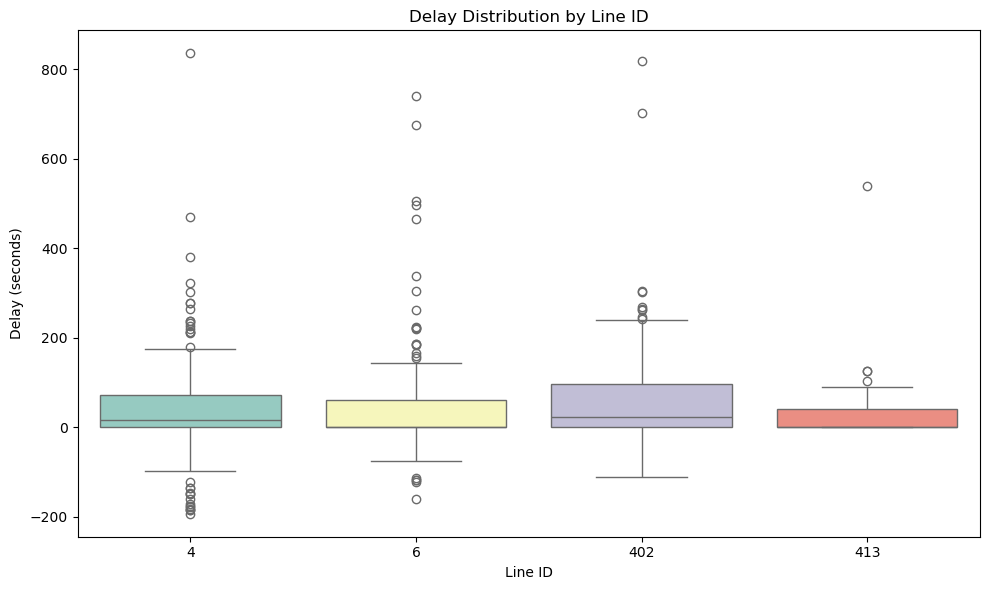

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_copy, x='line.id', y='delay', palette='Set3')

plt.title('Delay Distribution by Line ID')
plt.xlabel('Line ID')
plt.ylabel('Delay (seconds)')
plt.tight_layout()
plt.savefig('boxplot_all.png', dpi=300)  # ← Save here
plt.show()

### Shorter and Longer

In [9]:
#summary_a
summary_a[['group_a', 'count','mean', 'median', 'std', 'ci', 'punctuality(%)']]

,group_a,count,mean,median,std,ci,punctuality(%)
0,Longer Route(4 & 413),237,40.3,11.0,110.4,14.1,64.1
1,Shorter Route(6 & 402),292,54.5,0.0,121.5,13.9,66.8


In [428]:
## for group a, t-test
from scipy.stats import ttest_ind

# Extract delay values for each group
group_1_delays = filtered_copy[filtered_copy['group_a'] == "Shorter Route(6 & 402)"]['delay']
group_2_delays = filtered_copy[filtered_copy['group_a'] == "Longer Route(4 & 413)"]['delay']
t_stat, p_value = ttest_ind(group_1_delays, group_2_delays, equal_var=False)

# Display results
print("T-test between Shorter Route(6 & 402) and Longer Route(4 & 413):")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Statistically significant difference in delay between the two groups.")
else:
    print("❌ No statistically significant difference in delay between the two groups.")

T-test between Shorter Route(6 & 402) and Longer Route(4 & 413):
t-statistic: 1.4059
p-value: 0.1604
❌ No statistically significant difference in delay between the two groups.


/var/folders/pd/dr9kbswj1c3brg3llqmr7q6m0000gn/T/ipykernel_72053/2600736230.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_copy, x='group_a', y='delay', palette='Set2')


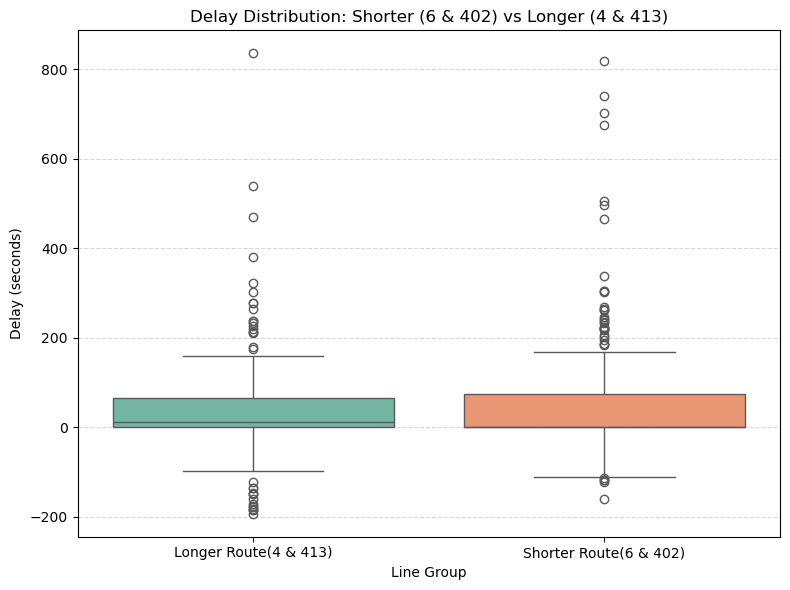

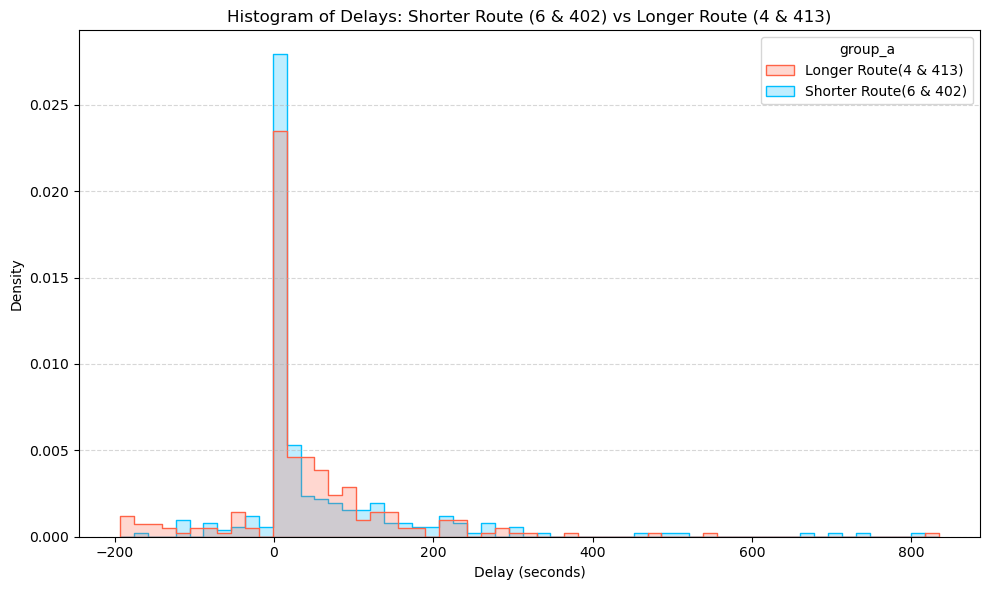

In [430]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered_copy, x='group_a', y='delay', palette='Set2')

plt.title('Delay Distribution: Shorter (6 & 402) vs Longer (4 & 413)')
plt.xlabel('Line Group')
plt.ylabel('Delay (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('boxplot_shorter_vs_longer.png', dpi=300)  # ← Save here
plt.show()

# Shorter vs Longer Route
plt.figure(figsize=(10, 6))
sns.histplot(
    data=filtered_copy,
    x='delay',
    hue='group_a',
    element='step',
    stat='density',
    common_norm=False,
    palette={
        'Shorter Route(6 & 402)': 'deepskyblue',
        'Longer Route(4 & 413)': 'tomato'
    }
)
plt.title('Histogram of Delays: Shorter Route (6 & 402) vs Longer Route (4 & 413)')
plt.xlabel('Delay (seconds)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('histogram_shorter_vs_longer.png', dpi=300)  # ← Save here
plt.show()

/var/folders/pd/dr9kbswj1c3brg3llqmr7q6m0000gn/T/ipykernel_72053/1276659897.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=non_zero_delays, x='group_a', y='delay', palette='Set2')


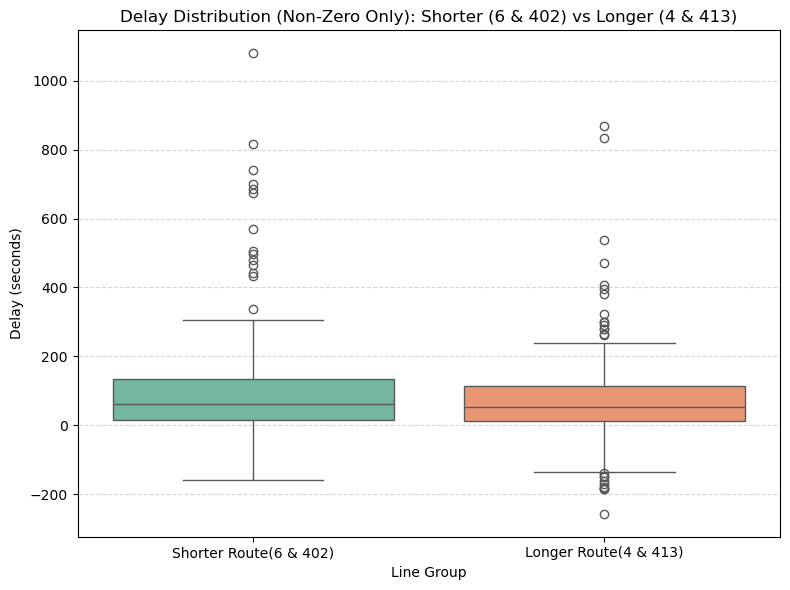

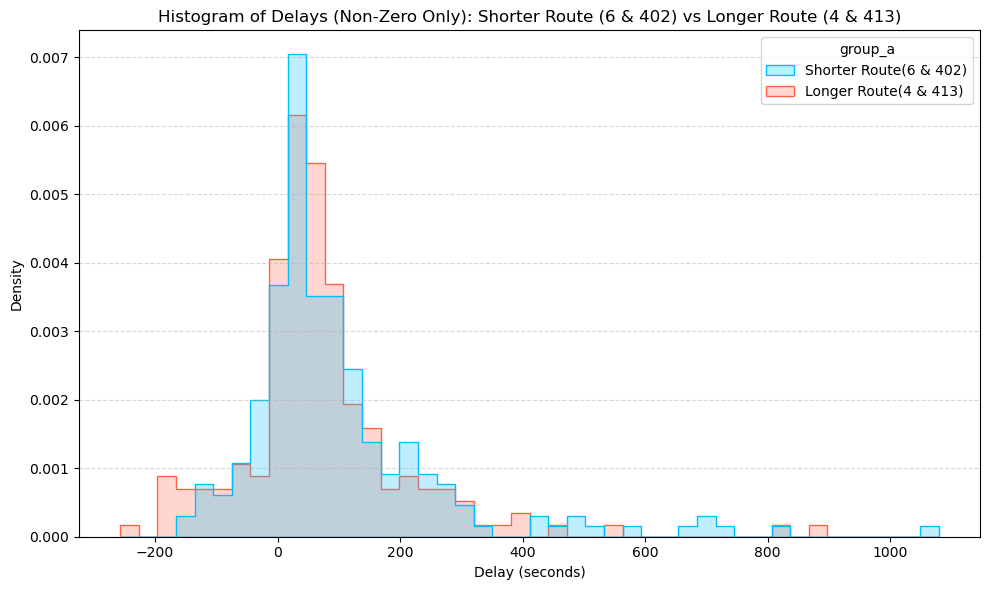

In [100]:
# Step 1: Filter out zero delays
non_zero_delays = filtered_copy[filtered_copy['delay'] != 0]

# Boxplot: Non-zero delays only
plt.figure(figsize=(8, 6))
sns.boxplot(data=non_zero_delays, x='group_a', y='delay', palette='Set2')
plt.title('Delay Distribution (Non-Zero Only): Shorter (6 & 402) vs Longer (4 & 413)')
plt.xlabel('Line Group')
plt.ylabel('Delay (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('boxplot_shorter_vs_longer_nonzero.png', dpi=300)
plt.show()

# Histogram: Non-zero delays only
plt.figure(figsize=(10, 6))
sns.histplot(
    data=non_zero_delays,
    x='delay',
    hue='group_a',
    element='step',
    stat='density',
    common_norm=False,
    palette={
        'Shorter Route(6 & 402)': 'deepskyblue',
        'Longer Route(4 & 413)': 'tomato'
    }
)
plt.title('Histogram of Delays (Non-Zero Only): Shorter Route (6 & 402) vs Longer Route (4 & 413)')
plt.xlabel('Delay (seconds)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('histogram_shorter_vs_longer_nonzero.png', dpi=300)
plt.show()


In [102]:
import numpy as np

# Group by group_a
summary_a_nonzero = (
    non_zero_delays.groupby('group_a')['delay']
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .reset_index()
)

# 95% confidence interval
summary_a_nonzero['ci'] = 1.96 * (summary_a_nonzero['std'] / np.sqrt(summary_a_nonzero['count']))

# Count delays > 60s
delay_over_60_a_nonzero = (
    non_zero_delays[non_zero_delays['delay'].abs() > 60]
    .groupby('group_a')['delay']
    .count()
    .reset_index()
    .rename(columns={'delay': 'delay_over_60_count'})
)

# Merge and compute punctuality
summary_a_nonzero = summary_a_nonzero.merge(delay_over_60_a_nonzero, on='group_a', how='left')
summary_a_nonzero['delay_over_60_count'] = summary_a_nonzero['delay_over_60_count'].fillna(0).astype(int)
summary_a_nonzero['punctuality(%)'] = 100 * (1 - summary_a_nonzero['delay_over_60_count'] / summary_a_nonzero['count'])

# Round values
columns_to_round = ['mean', 'median', 'std', 'min', 'max', 'ci', 'punctuality(%)']
summary_a_nonzero[columns_to_round] = summary_a_nonzero[columns_to_round].round(1)

# Display selected columns
selected_columns_a = ['group_a', 'mean', 'median', 'std', 'min', 'max', 'ci']
summary_a_nonzero_display = summary_a_nonzero[selected_columns_a]
summary_a_nonzero_display

,group_a,mean,median,std,min,max,ci
0,Longer Route(4 & 413),72.9,52.0,143.7,-257.0,868.0,20.6
1,Shorter Route(6 & 402),100.8,61.0,166.9,-160.0,1080.0,22.3


In [70]:
from scipy.stats import mannwhitneyu

# Filter non-zero delays
non_zero = filtered_copy[filtered_copy['delay'].abs() > 0]

# Group delays
shorter_delays = non_zero[non_zero['group_a'] == "Shorter Route(6 & 402)"]['delay']
longer_delays = non_zero[non_zero['group_a'] == "Longer Route(4 & 413)"]['delay']

# Mann–Whitney U test
u_stat, p_value = mannwhitneyu(shorter_delays, longer_delays, alternative='two-sided')

print("Mann–Whitney U Test (Non-Zero Delays Only):")
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Statistically significant difference in delay distributions.")
else:
    print("❌ No statistically significant difference in delay distributions.")


Mann–Whitney U Test (Non-Zero Delays Only):
U-statistic: 21297.0
P-value: 0.3042
❌ No statistically significant difference in delay distributions.


In [104]:
from scipy.stats import ttest_ind

# Filter non-zero delays (already done above)
non_zero = filtered_copy[filtered_copy['delay'].abs() > 0]

# Group delays
shorter_delays = non_zero[non_zero['group_a'] == "Shorter Route(6 & 402)"]['delay']
longer_delays = non_zero[non_zero['group_a'] == "Longer Route(4 & 413)"]['delay']

# Welch’s t-test (assumes unequal variances)
t_stat, p_value = ttest_ind(shorter_delays, longer_delays, equal_var=False)

# Print results
print("Welch's t-test (Non-Zero Delays Only): Shorter Route vs Longer Route")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Statistically significant difference in mean delay.")
else:
    print("❌ No statistically significant difference in mean delay.")

Welch's t-test (Non-Zero Delays Only): Shorter Route vs Longer Route
T-statistic: 1.8028
P-value: 0.0722
❌ No statistically significant difference in mean delay.


### Red and Blue

In [436]:
summary_b[['group_b', 'mean', 'median', 'std', 'ci', 'punctuality(%)']]

,group_b,mean,median,std,ci,punctuality(%)
0,Suburban(402 & 413),62.9,7.0,121.4,19.6,65.3
1,Urban(4 & 6),42.5,5.0,114.6,11.5,65.7


/var/folders/pd/dr9kbswj1c3brg3llqmr7q6m0000gn/T/ipykernel_72053/371235509.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_copy, x='group_b', y='delay', palette='Set3')


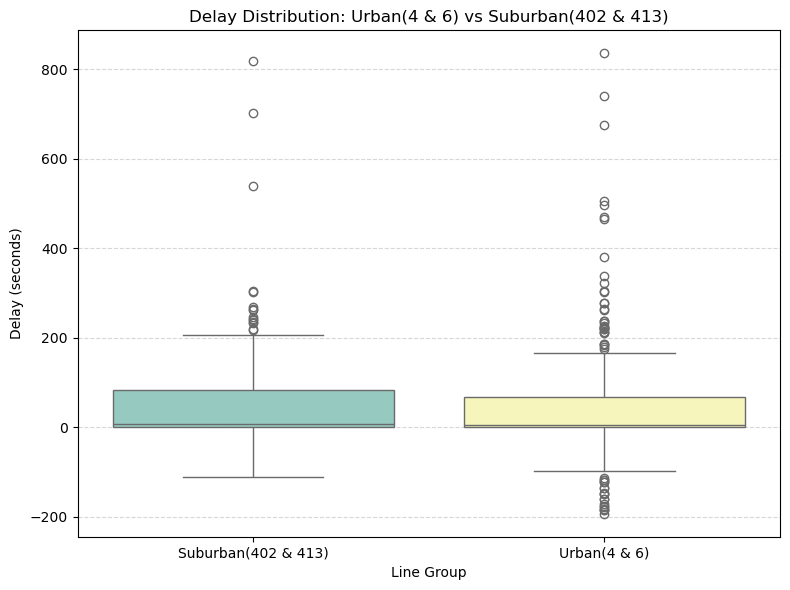

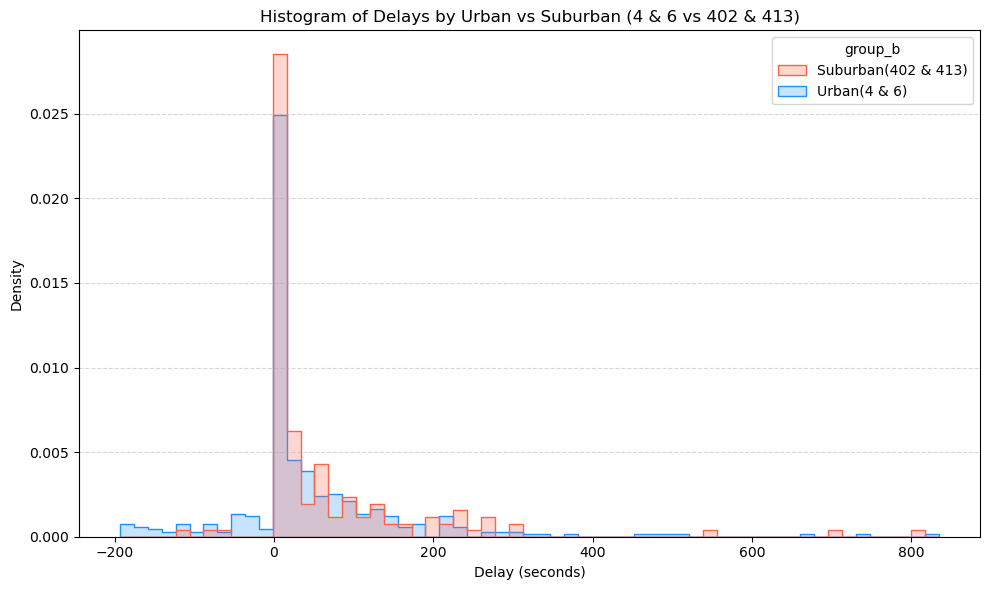

In [440]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered_copy, x='group_b', y='delay', palette='Set3')

plt.title('Delay Distribution: Urban(4 & 6) vs Suburban(402 & 413)')
plt.xlabel('Line Group')
plt.ylabel('Delay (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('box-plot_urban_vs_suburban.png', dpi=300)  # ← Save here

plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(
    data=filtered_copy,
    x='delay',
    hue='group_b',
    element='step',
    stat='density',
    common_norm=False,
    palette={'Urban(4 & 6)': 'dodgerblue', 'Suburban(402 & 413)': 'tomato'}
)

plt.title('Histogram of Delays by Urban vs Suburban (4 & 6 vs 402 & 413)')
plt.xlabel('Delay (seconds)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('histogram_urban_vs_suburban.png', dpi=300)  # ← Save here
plt.show()

In [102]:
## for group b
from scipy.stats import ttest_ind

# Extract delay values for each group
group_a_delays = filtered_copy[filtered_copy['group_b'] == "Urban(4 & 6)"]['delay']
group_b_delays = filtered_copy[filtered_copy['group_b'] == "Suburban(402 & 413)"]['delay']

# Conduct independent t-test (Welch’s t-test: does not assume equal variances)
t_stat, p_value = ttest_ind(group_a_delays, group_b_delays, equal_var=False)

# Display results
print("T-test between Urban Route(4 & 6) and Suburban Route(402 & 413):")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.1:
    print("✅ Statistically significant difference in delay between the two groups.")
else:
    print("❌ No statistically significant difference in delay between the two groups.")

T-test between Urban Route(4 & 6) and Suburban Route(402 & 413):
t-statistic: -1.7638
p-value: 0.0790
✅ Statistically significant difference in delay between the two groups.


### OLD: Take the maximum

In [359]:
filtered_db = pd.concat([df_mon, df_tue, df_wed, df_fri])
filtered_db.loc[filtered_db["delay"] < 0, "delay"] = 0
#filtered_db['station_name'].unique()

In [361]:
filtered_db = filtered_db[['destination', 'direction_code', 'state', 'delay', 'station_name', 'line.id',
       'collected_at',  'line.transport_mode',  'scheduled',  'expected', 'direction', 
       'deviations', 'journey.id', 'journey.state', 'stop_area.id', 'stop_area.name',
       'stop_area.type', 'stop_point.id', 'display','stop_point.name', 
       'line.designation', 'site_id',  'hour', 'minute', 'time']]
target_ids = [4, 6, 402, 413]
filtered_db = filtered_db.loc[(filtered_db["line.transport_mode"]=="BUS") & (filtered_db["line.id"].isin(target_ids))]
filtered_db['collected_at'] = pd.to_datetime(filtered_db['collected_at'])

# Step 0: reset index to ensure it's clean
filtered_db = filtered_db.reset_index(drop=True)

# Step 1: groupby and take the row with max delay per journey.id
filtered_db = filtered_db.loc[
    filtered_db.groupby('journey.id')['delay'].idxmax()
].reset_index(drop=True)

print(filtered_db[filtered_db['line.id'] == 4].shape)

# Group by line.id and describe the delay column
summary = filtered_db.groupby('line.id')['delay'].describe()

# Optional: reset index if you want a clean DataFrame
summary = summary.reset_index()

# Show the summary table
print(summary)

(211, 25)
   line.id  count        mean         std  min   25%   50%    75%     max
0        4  211.0  107.554502  117.777072  0.0  26.0  77.0  145.5   885.0
1        6  175.0   86.085714  126.852927  0.0   0.0  41.0  120.5   749.0
2      402  170.0   95.076471  153.399544  0.0   0.0  39.0  125.0  1080.0
3      413   73.0   87.835616  170.478494  0.0   0.0   0.0  103.0   868.0


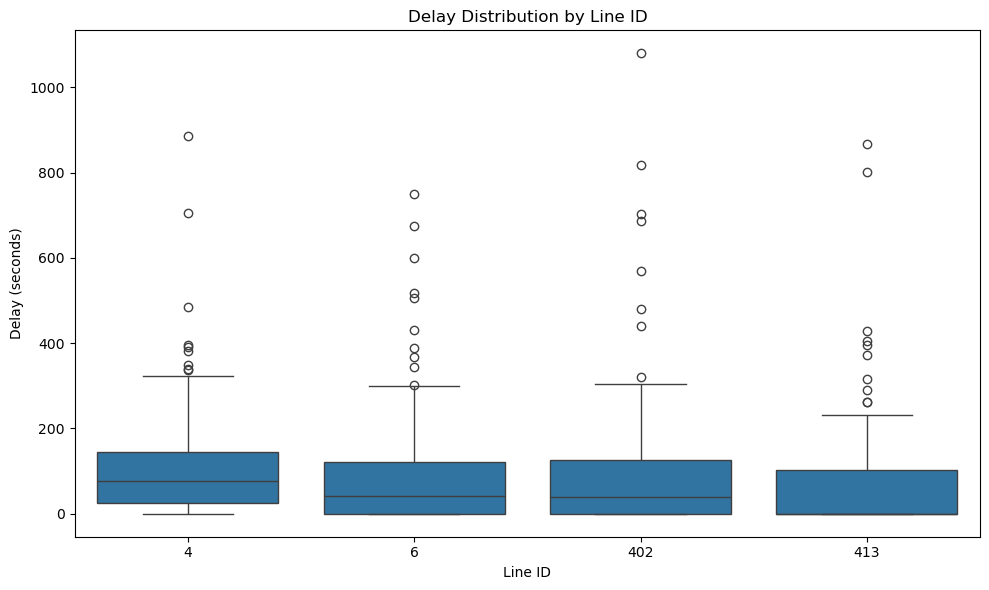

In [363]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_db, x='line.id', y='delay')

plt.title('Delay Distribution by Line ID')
plt.xlabel('Line ID')
plt.ylabel('Delay (seconds)')
plt.tight_layout()
plt.show()

In [ ]:
### punctuality inconve

### Line graph about punctuality

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data
df = pd.DataFrame({
    'line.id': [4, 6, 402, 413],
    'first': [98.09, 99.31, 97.22, 100],
    'middle': [46.26, 56, 53.85, 61.9],
    'last': [70.09, 74.59, 68.88, 76.39]
}).set_index('line.id')

# Define custom colors
color_map = {
    4: 'steelblue',
    6: 'seagreen',
    402: 'darkorange',
    413: 'crimson'
}

# Plot
plt.figure(figsize=(10, 6))
for idx in df.index:
    plt.plot(df.columns, df.loc[idx], marker='o', label=f'Line {idx}', color=color_map[idx])

plt.title('Punctuality by Position (First, Middle, Last)')
plt.xlabel('Position in Route')
plt.ylabel('Value')
plt.ylim(0, None)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Line ID')
plt.tight_layout()
plt.savefig('line_graph_nonzero.png', dpi=300)
plt.show()

### inpunctuality inconvenience

In [74]:
# Step 1: Define departures per hour for each line
import numpy as np
departures_per_hour = {4: 8, 6: 6, 402: 6, 413: 3}

# Step 2: Calculate headway (minutes between departures)
# Headway = 60 minutes / number of departures per hour
filtered_copy['headway'] = filtered_copy['line.id'].map(lambda x: 60 / departures_per_hour.get(x, np.nan))

# Step 3: Convert delay from seconds to minutes
filtered_copy['delay(mins)'] = filtered_copy['delay'] / 60
filtered_copy.shape

(529, 27)

In [76]:
def service_unreliability(y):
    if y <= -2:
        return 0
    elif -2 < y <= 2:
        return 0.0054 * (y + 2)**3
    elif 2 < y <= 9:
        return 1 - 0.005 * (9 - y)**2.5
    else:
        return 1

filtered_copy['P'] = filtered_copy['delay(mins)'].apply(service_unreliability)
filtered_copy.shape

(529, 28)

In [82]:
def unpunctuality_inconvenience(y, H):
    if y <= -2:
        return 1.3 * y - 1.6
    elif -2 < y <= 0:
        return -0.5 * y
    elif 0 < y <= 6:
        return 0.162 * y
    else:
        return 0.97 * H

filtered_copy['u'] = filtered_copy.apply(lambda row: unpunctuality_inconvenience(row['delay(mins)'], row['headway']), axis=1)
filtered_copy.shape

(529, 29)

In [84]:
filtered_copy

,destination,direction_code,state,delay,station_name,line.id,collected_at,line.transport_mode,scheduled,expected,direction,deviations,journey.id,journey.state,stop_area.id,stop_area.name,stop_area.type,stop_point.id,display,stop_point.name,line.designation,site_id,hour,minute,time,headway,delay(mins),P,u
0,Björknäs,1,EXPECTED,0.0,Londonviadukten,413,2025-04-29 06:56:02,BUS,2025-04-29 07:43:08,2025-04-29 07:43:08,Talludden,[],2025042900007,EXPECTED,10591,Londonviadukten,BUSTERM,40003,07:43,Londonviadukten,413,1461,7,43,07:43:08,20.0,0.000000,0.043200,-0.0000
1,Nacka Forum,1,EXPECTED,24.0,Londonviadukten,402,2025-04-29 07:02:07,BUS,2025-04-29 07:03:02,2025-04-29 07:03:26,Nacka Forum,[],2025042900009,NORMALPROGRESS,10591,Londonviadukten,BUSTERM,10591,2 min,Londonviadukten,402,1461,7,3,07:03:02,10.0,0.400000,0.074650,0.0648
2,Nacka Forum,1,EXPECTED,0.0,Nacka gymnasium,402,2025-04-29 06:56:02,BUS,2025-04-29 07:28:09,2025-04-29 07:28:09,Nacka Forum,[],2025042900011,EXPECTED,40523,Nacka gymnasium,BUSTERM,40521,07:28,Nacka gymnasium,402,4063,7,28,07:28:09,10.0,0.000000,0.043200,-0.0000
3,Slussen,2,EXPECTED,64.0,Londonviadukten,402,2025-04-29 07:02:07,BUS,2025-04-29 07:04:15,2025-04-29 07:05:19,Slussen,[],2025042900012,NORMALPROGRESS,10591,Londonviadukten,BUSTERM,10594,4 min,Londonviadukten,402,1461,7,4,07:04:15,10.0,1.066667,0.155738,0.1728
4,Björknäs,1,EXPECTED,539.0,Londonviadukten,413,2025-04-29 08:51:09,BUS,2025-04-29 08:43:08,2025-04-29 08:52:07,Talludden,[],2025042900013,NORMALPROGRESS,10591,Londonviadukten,BUSTERM,40003,1 min,Londonviadukten,413,1461,8,43,08:43:08,20.0,8.983333,1.000000,19.4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Talludden,1,EXPECTED,0.0,Glasbrukssjön,413,2025-05-16 08:32:38,BUS,2025-05-16 09:13:04,2025-05-16 09:13:04,Talludden,[],2025051600015,EXPECTED,40291,Glasbrukssjön,BUSTERM,40291,09:13,Glasbrukssjön,413,4181,9,13,09:13:04,20.0,0.000000,0.043200,-0.0000
525,Gullmarsplan,1,EXPECTED,0.0,Garnisonen,4,2025-04-30 07:19:57,BUS,2025-04-30 07:31:24,2025-04-30 07:31:24,Gullmarsplan,[],2025043030646,EXPECTED,10627,Garnisonen,BUSTERM,10627,19 min,Garnisonen,4,1113,7,31,07:31:24,7.5,0.000000,0.043200,-0.0000
526,Slussen,2,EXPECTED,0.0,Nacka gymnasium,402,2025-05-02 07:48:03,BUS,2025-05-02 08:15:05,2025-05-02 08:15:05,Slussen,[],2025050200022,EXPECTED,40523,Nacka gymnasium,BUSTERM,40522,27 min,Nacka gymnasium,402,4063,8,15,08:15:05,10.0,0.000000,0.043200,-0.0000
527,Talludden,1,EXPECTED,126.0,Glasbrukssjön,413,2025-05-16 09:52:07,BUS,2025-05-16 09:52:20,2025-05-16 09:54:26,Talludden,[],2025051600021,NORMALPROGRESS,40291,Glasbrukssjön,BUSTERM,40291,2 min,Glasbrukssjön,413,4181,9,52,09:52:20,20.0,2.100000,0.374694,0.3402


In [88]:
summary_u = filtered_copy.groupby('line.id')[['P', 'u']].mean().round(2)
summary_u

,P,u
line.id,,
4,0.16,-0.08
6,0.15,0.37
402,0.20,0.34
413,0.13,0.75


## Extra test

🚌 BUS DELAY STATISTICAL TESTS
Sample sizes:
Line 4: 209 observations
Line 6: 173 observations
Line 402: 119 observations
Line 413: 28 observations

Descriptive Statistics:
------------------------------
Line 4: Mean=40.08, Std=111.05, Median=16.00
Line 6: Mean=45.32, Std=118.41, Median=0.00
Line 402: Mean=67.85, Std=124.16, Median=23.00
Line 413: Mean=41.96, Std=103.63, Median=0.00

1. OVERALL TESTS (All 4 Lines)
One-Way ANOVA:
  F-statistic: 1.5258
  p-value: 0.206837
  Significant: No

Kruskal-Wallis Test:
  H-statistic: 7.7057
  p-value: 0.052503
  Significant: No

2. PAIRWISE COMPARISONS

Line 4 vs Line 413:
------------------------------
  Line 4: n=209, mean=40.08
  Line 413: n=28, mean=41.96
  Mean difference: -1.88
  
  Independent t-test:
    t-statistic: -0.0845
    p-value: 0.932692
    Significant: No
    Effect size (Cohen's d): -0.0170
  
  Mann-Whitney U test:
    U-statistic: 3291.0000
    p-value: 0.276907
    Significant: No

Line 6 vs Line 402:
----------------------

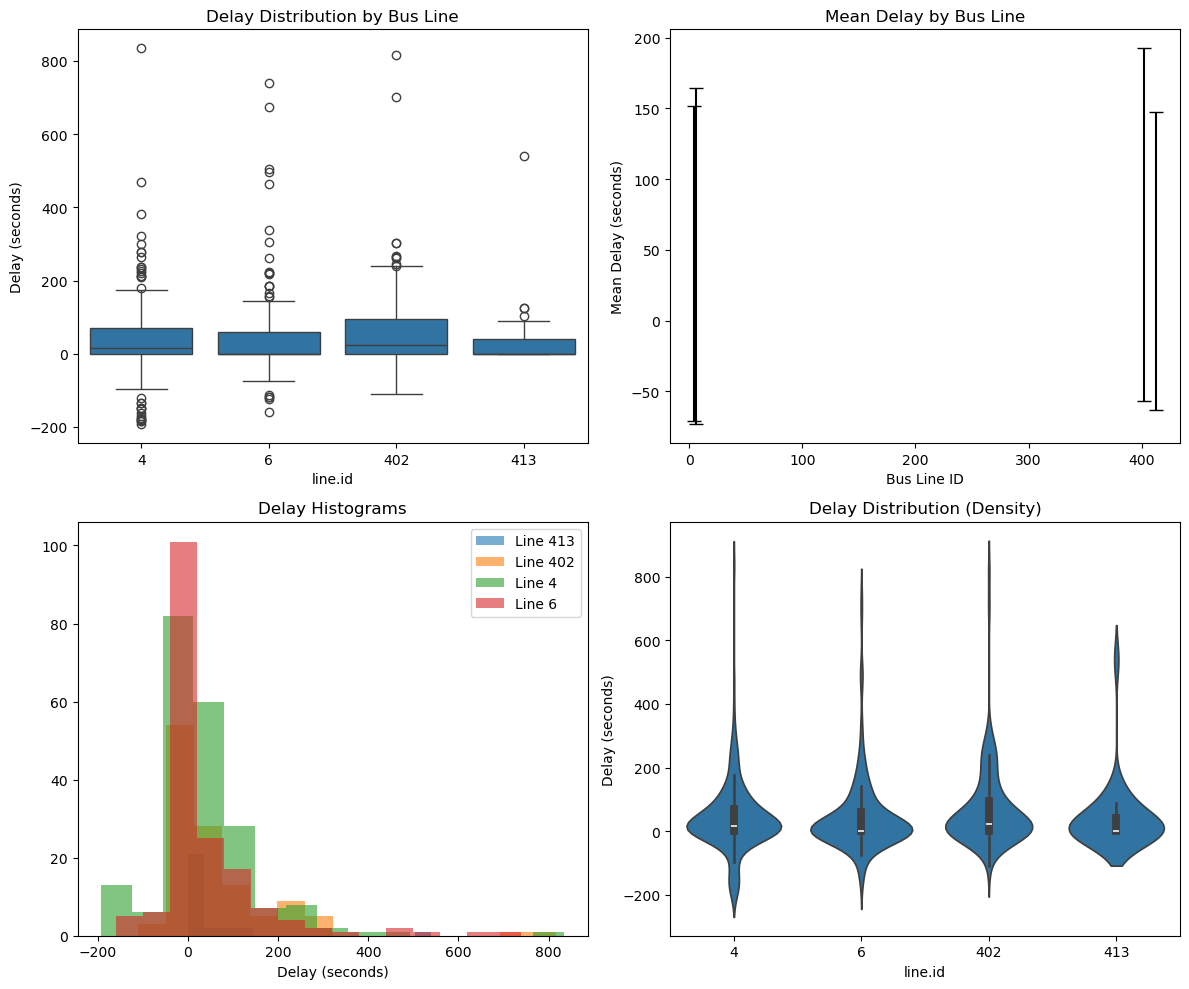


5. INTERPRETATION
🔍 Mann-Whitney test found significant differences in:
   • Line 6 vs Line 402


In [20]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu, shapiro, levene, f_oneway
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your filtered_copy dataframe is ready from your previous code
# Let's perform comprehensive statistical analysis

def check_normality_and_variance(data_dict):
    """
    Check normality and homogeneity of variance assumptions
    """
    print("=== ASSUMPTION TESTING ===")
    print("\n1. Normality Tests (Shapiro-Wilk):")
    print("-" * 50)
    
    normality_results = {}
    for line_id, delays in data_dict.items():
        if len(delays) >= 3:  # Need at least 3 samples for Shapiro-Wilk
            stat, p_value = shapiro(delays)
            normality_results[line_id] = p_value > 0.05
            print(f"Line {line_id}: p-value = {p_value:.6f}, Normal = {p_value > 0.05}")
        else:
            normality_results[line_id] = False
            print(f"Line {line_id}: Insufficient data for normality test")
    
    print(f"\nAll groups normal: {all(normality_results.values())}")
    
    # Test homogeneity of variance (Levene's test)
    print("\n2. Homogeneity of Variance (Levene's Test):")
    print("-" * 50)
    
    # Only test if we have at least 2 groups with sufficient data
    valid_groups = [delays for delays in data_dict.values() if len(delays) >= 3]
    if len(valid_groups) >= 2:
        levene_stat, levene_p = levene(*valid_groups)
        equal_variance = levene_p > 0.05
        print(f"Levene's test p-value: {levene_p:.6f}")
        print(f"Equal variances: {equal_variance}")
        return all(normality_results.values()), equal_variance
    else:
        print("Insufficient data for variance test")
        return all(normality_results.values()), True

def perform_overall_test(data_dict, assumptions_met):
    """
    Perform overall test for differences between all groups
    """
    print("\n=== OVERALL TEST (All 4 Lines) ===")
    print("-" * 50)
    
    # Prepare data for testing
    delays_list = [delays for delays in data_dict.values() if len(delays) > 0]
    line_ids = [line_id for line_id, delays in data_dict.items() if len(delays) > 0]
    
    if len(delays_list) < 2:
        print("Insufficient groups for testing")
        return
    
    if assumptions_met:
        # Use ANOVA if assumptions are met
        print("Using One-Way ANOVA (parametric test)")
        f_stat, p_value = f_oneway(*delays_list)
        test_name = "One-Way ANOVA"
    else:
        # Use Kruskal-Wallis if assumptions are violated
        print("Using Kruskal-Wallis Test (non-parametric test)")
        h_stat, p_value = kruskal(*delays_list)
        test_name = "Kruskal-Wallis"
    
    print(f"{test_name} Results:")
    print(f"Test statistic: {f_stat if assumptions_met else h_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    if p_value < 0.05:
        print("⚠️  There IS a significant difference between at least two bus lines")
    else:
        print("✅ No significant difference found between bus lines")

def perform_pairwise_tests(data_dict, assumptions_met):
    """
    Perform pairwise comparisons
    """
    print("\n=== PAIRWISE COMPARISONS ===")
    print("-" * 50)
    
    # Define the specific pairs you want to test
    pairs_to_test = [
        (4, 413, "Line 4 vs Line 413"),
        (6, 402, "Line 6 vs Line 402"), 
        (4, 6, "Line 4 vs Line 6"),
        (402, 413, "Line 402 vs Line 413")
    ]
    
    results = []
    
    for line1, line2, comparison_name in pairs_to_test:
        print(f"\n{comparison_name}:")
        print("-" * 30)
        
        # Check if both groups have data
        if line1 not in data_dict or line2 not in data_dict:
            print(f"Missing data for one or both lines")
            continue
            
        group1 = data_dict[line1]
        group2 = data_dict[line2]
        
        if len(group1) == 0 or len(group2) == 0:
            print(f"No data available for comparison")
            continue
            
        # Descriptive statistics
        print(f"Line {line1}: n={len(group1)}, mean={np.mean(group1):.2f}, std={np.std(group1):.2f}")
        print(f"Line {line2}: n={len(group2)}, mean={np.mean(group2):.2f}, std={np.std(group2):.2f}")
        
        # Choose appropriate test
        if assumptions_met and len(group1) >= 3 and len(group2) >= 3:
            # Use t-test if assumptions are met
            stat, p_value = stats.ttest_ind(group1, group2, equal_var=True)
            test_used = "Independent t-test"
        else:
            # Use Mann-Whitney U test if assumptions are violated
            stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
            test_used = "Mann-Whitney U test"
        
        print(f"Test used: {test_used}")
        print(f"Test statistic: {stat:.4f}")
        print(f"p-value: {p_value:.6f}")
        print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
        
        # Effect size (Cohen's d for t-test, or r for Mann-Whitney)
        if assumptions_met and len(group1) >= 3 and len(group2) >= 3:
            pooled_std = np.sqrt(((len(group1) - 1) * np.var(group1, ddof=1) + 
                                (len(group2) - 1) * np.var(group2, ddof=1)) / 
                               (len(group1) + len(group2) - 2))
            cohens_d = (np.mean(group1) - np.mean(group2)) / pooled_std
            print(f"Effect size (Cohen's d): {cohens_d:.4f}")
        else:
            # For Mann-Whitney, calculate r = Z / sqrt(N)
            z_score = stats.norm.ppf(p_value/2)  # Convert p to Z (approximate)
            r = abs(z_score) / np.sqrt(len(group1) + len(group2))
            print(f"Effect size (r): {r:.4f}")
        
        results.append({
            'Comparison': comparison_name,
            'Test': test_used,
            'p-value': p_value,
            'Significant': p_value < 0.05,
            'Mean_Diff': np.mean(group1) - np.mean(group2)
        })
    
    # Summary table
    print("\n=== PAIRWISE RESULTS SUMMARY ===")
    print("-" * 50)
    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))
    
    return results_df

def create_visualizations(filtered_copy):
    """
    Create visualizations for the delay data
    """
    plt.figure(figsize=(15, 10))
    
    # 1. Box plot
    plt.subplot(2, 2, 1)
    sns.boxplot(data=filtered_copy, x='line.id', y='delay')
    plt.title('Delay Distribution by Bus Line')
    plt.ylabel('Delay (seconds)')
    plt.xlabel('Bus Line ID')
    
    # 2. Violin plot
    plt.subplot(2, 2, 2)
    sns.violinplot(data=filtered_copy, x='line.id', y='delay')
    plt.title('Delay Distribution (Density) by Bus Line')
    plt.ylabel('Delay (seconds)')
    plt.xlabel('Bus Line ID')
    
    # 3. Histogram
    plt.subplot(2, 2, 3)
    for line_id in filtered_copy['line.id'].unique():
        line_delays = filtered_copy[filtered_copy['line.id'] == line_id]['delay']
        plt.hist(line_delays, alpha=0.6, label=f'Line {line_id}', bins=20)
    plt.title('Delay Histograms by Bus Line')
    plt.xlabel('Delay (seconds)')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 4. Summary statistics bar plot
    plt.subplot(2, 2, 4)
    summary_stats = filtered_copy.groupby('line.id')['delay'].agg(['mean', 'std']).reset_index()
    x_pos = range(len(summary_stats))
    plt.bar(x_pos, summary_stats['mean'], yerr=summary_stats['std'], 
            capsize=5, alpha=0.7)
    plt.xticks(x_pos, summary_stats['line.id'])
    plt.title('Mean Delay by Bus Line (with Standard Deviation)')
    plt.xlabel('Bus Line ID')
    plt.ylabel('Mean Delay (seconds)')
    
    plt.tight_layout()
    plt.show()

# Main analysis function
def analyze_bus_delays(filtered_copy):
    """
    Complete statistical analysis of bus delay data
    """
    print("🚌 BUS DELAY STATISTICAL ANALYSIS")
    print("=" * 60)
    
    # Prepare data dictionary
    data_dict = {}
    for line_id in [4, 6, 402, 413]:
        line_data = filtered_copy[filtered_copy['line.id'] == line_id]['delay'].values
        data_dict[line_id] = line_data
        print(f"Line {line_id}: {len(line_data)} observations")
    
    print()
    
    # Check assumptions
    normality, equal_variance = check_normality_and_variance(data_dict)
    assumptions_met = normality and equal_variance
    
    print(f"\nParametric test assumptions met: {assumptions_met}")
    if not assumptions_met:
        print("Will use non-parametric tests")
    
    # Overall test
    perform_overall_test(data_dict, assumptions_met)
    
    # Pairwise tests
    pairwise_results = perform_pairwise_tests(data_dict, assumptions_met)
    
    # Create visualizations
    create_visualizations(filtered_copy)
    
    # Final recommendations
    print("\n=== RECOMMENDATIONS ===")
    print("-" * 50)
    significant_pairs = pairwise_results[pairwise_results['Significant']]['Comparison'].tolist()
    
    if significant_pairs:
        print("🔍 Significant differences found between:")
        for pair in significant_pairs:
            print(f"   • {pair}")
        print("\n💡 Consider investigating operational differences between these lines")
    else:
        print("✅ No significant differences found between any bus line pairs")
        print("💡 All bus lines show similar delay performance")
    
    return pairwise_results

# Run the analysis
#Make sure your filtered_copy dataframe is ready, then call:
results = analyze_bus_delays(filtered_copy)

🚌 BUS DELAY STATISTICAL TESTS
Sample sizes:
Line 4: 209 observations
Line 6: 173 observations
Line 402: 119 observations
Line 413: 28 observations

Descriptive Statistics:
------------------------------
Line 4: Mean=40.08, Std=111.05, Median=16.00
Line 6: Mean=45.32, Std=118.41, Median=0.00
Line 402: Mean=67.85, Std=124.16, Median=23.00
Line 413: Mean=41.96, Std=103.63, Median=0.00

1. OVERALL TESTS (All 4 Lines)
One-Way ANOVA:
  F-statistic: 1.5258
  p-value: 0.206837
  Significant: No

Kruskal-Wallis Test:
  H-statistic: 7.7057
  p-value: 0.052503
  Significant: No

2. PAIRWISE COMPARISONS

Line 4 vs Line 413:
------------------------------
  Line 4: n=209, mean=40.08
  Line 413: n=28, mean=41.96
  Mean difference: -1.88
  
  Independent t-test:
    t-statistic: -0.0845
    p-value: 0.932692
    Significant: No
    Effect size (Cohen's d): -0.0170
  
  Mann-Whitney U test:
    U-statistic: 3291.0000
    p-value: 0.276907
    Significant: No

Line 6 vs Line 402:
----------------------

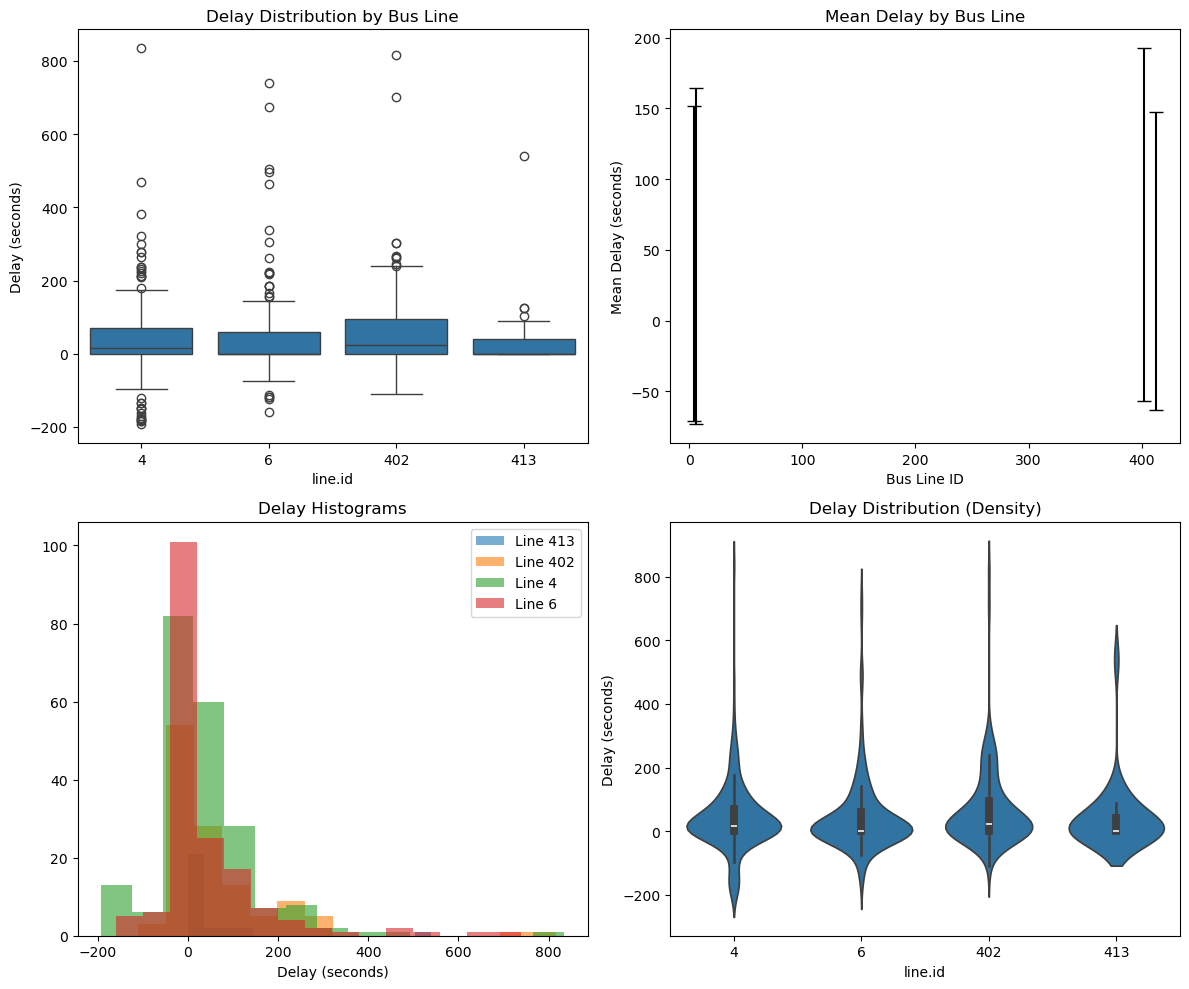


5. INTERPRETATION
🔍 Mann-Whitney test found significant differences in:
   • Line 6 vs Line 402


In [22]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway, kruskal
import matplotlib.pyplot as plt
import seaborn as sns

def run_bus_delay_tests(filtered_copy):
    """
    Run statistical tests directly on bus delay data
    """
    print("🚌 BUS DELAY STATISTICAL TESTS")
    print("=" * 50)
    
    # Extract delay data for each line
    line_4 = filtered_copy[filtered_copy['line.id'] == 4]['delay'].values
    line_6 = filtered_copy[filtered_copy['line.id'] == 6]['delay'].values
    line_402 = filtered_copy[filtered_copy['line.id'] == 402]['delay'].values
    line_413 = filtered_copy[filtered_copy['line.id'] == 413]['delay'].values
    
    # Display basic info
    print("Sample sizes:")
    print(f"Line 4: {len(line_4)} observations")
    print(f"Line 6: {len(line_6)} observations") 
    print(f"Line 402: {len(line_402)} observations")
    print(f"Line 413: {len(line_413)} observations")
    
    print("\nDescriptive Statistics:")
    print("-" * 30)
    for line_id, data in [(4, line_4), (6, line_6), (402, line_402), (413, line_413)]:
        if len(data) > 0:
            print(f"Line {line_id}: Mean={np.mean(data):.2f}, Std={np.std(data):.2f}, Median={np.median(data):.2f}")
        else:
            print(f"Line {line_id}: No data available")
    
    # 1. OVERALL TESTS (All 4 lines together)
    print("\n" + "="*50)
    print("1. OVERALL TESTS (All 4 Lines)")
    print("="*50)
    
    # Collect all non-empty groups
    all_groups = []
    group_labels = []
    for line_id, data in [(4, line_4), (6, line_6), (402, line_402), (413, line_413)]:
        if len(data) > 0:
            all_groups.append(data)
            group_labels.append(f"Line {line_id}")
    
    if len(all_groups) >= 2:
        # ANOVA (parametric)
        try:
            f_stat, f_p = f_oneway(*all_groups)
            print(f"One-Way ANOVA:")
            print(f"  F-statistic: {f_stat:.4f}")
            print(f"  p-value: {f_p:.6f}")
            print(f"  Significant: {'Yes' if f_p < 0.05 else 'No'}")
        except:
            print("ANOVA could not be performed")
        
        # Kruskal-Wallis (non-parametric)
        try:
            h_stat, h_p = kruskal(*all_groups)
            print(f"\nKruskal-Wallis Test:")
            print(f"  H-statistic: {h_stat:.4f}")
            print(f"  p-value: {h_p:.6f}")
            print(f"  Significant: {'Yes' if h_p < 0.05 else 'No'}")
        except:
            print("Kruskal-Wallis could not be performed")
    
    # 2. PAIRWISE TESTS
    print("\n" + "="*50)
    print("2. PAIRWISE COMPARISONS")
    print("="*50)
    
    # Define pairs to test
    pairs = [
        (4, 413, line_4, line_413, "Line 4 vs Line 413"),
        (6, 402, line_6, line_402, "Line 6 vs Line 402"),
        (4, 6, line_4, line_6, "Line 4 vs Line 6"),
        (402, 413, line_402, line_413, "Line 402 vs Line 413")
    ]
    
    results = []
    
    for line1_id, line2_id, data1, data2, comparison_name in pairs:
        print(f"\n{comparison_name}:")
        print("-" * 30)
        
        if len(data1) == 0 or len(data2) == 0:
            print("  No data available for comparison")
            continue
        
        # Basic stats
        print(f"  Line {line1_id}: n={len(data1)}, mean={np.mean(data1):.2f}")
        print(f"  Line {line2_id}: n={len(data2)}, mean={np.mean(data2):.2f}")
        print(f"  Mean difference: {np.mean(data1) - np.mean(data2):.2f}")
        
        # T-test (parametric)
        try:
            t_stat, t_p = ttest_ind(data1, data2)
            print(f"  \n  Independent t-test:")
            print(f"    t-statistic: {t_stat:.4f}")
            print(f"    p-value: {t_p:.6f}")
            print(f"    Significant: {'Yes' if t_p < 0.05 else 'No'}")
            
            # Effect size (Cohen's d)
            pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1, ddof=1) + 
                                (len(data2) - 1) * np.var(data2, ddof=1)) / 
                               (len(data1) + len(data2) - 2))
            if pooled_std > 0:
                cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std
                print(f"    Effect size (Cohen's d): {cohens_d:.4f}")
        except:
            print("  T-test could not be performed")
            t_p = np.nan
        
        # Mann-Whitney U test (non-parametric)
        try:
            u_stat, u_p = mannwhitneyu(data1, data2, alternative='two-sided')
            print(f"  \n  Mann-Whitney U test:")
            print(f"    U-statistic: {u_stat:.4f}")
            print(f"    p-value: {u_p:.6f}")
            print(f"    Significant: {'Yes' if u_p < 0.05 else 'No'}")
        except:
            print("  Mann-Whitney U test could not be performed")
            u_p = np.nan
        
        # Store results
        results.append({
            'Comparison': comparison_name,
            'Line_1': line1_id,
            'Line_2': line2_id,
            'Mean_1': np.mean(data1) if len(data1) > 0 else np.nan,
            'Mean_2': np.mean(data2) if len(data2) > 0 else np.nan,
            'Mean_Diff': np.mean(data1) - np.mean(data2) if len(data1) > 0 and len(data2) > 0 else np.nan,
            't_test_p': t_p if 't_p' in locals() else np.nan,
            'mannwhitney_p': u_p if 'u_p' in locals() else np.nan,
            't_test_sig': t_p < 0.05 if not np.isnan(t_p) else False,
            'mannwhitney_sig': u_p < 0.05 if not np.isnan(u_p) else False
        })
    
    # 3. SUMMARY TABLE
    print("\n" + "="*50)
    print("3. RESULTS SUMMARY")
    print("="*50)
    
    results_df = pd.DataFrame(results)
    
    # Clean summary table
    summary_df = results_df[['Comparison', 'Mean_Diff', 't_test_p', 't_test_sig', 'mannwhitney_p', 'mannwhitney_sig']].copy()
    summary_df.columns = ['Comparison', 'Mean_Difference', 'T-test_p-value', 'T-test_Significant', 'Mann-Whitney_p-value', 'Mann-Whitney_Significant']
    
    print(summary_df.to_string(index=False, float_format='%.6f'))
    
    # 4. QUICK VISUALIZATION
    print("\n" + "="*50)
    print("4. CREATING VISUALIZATIONS...")
    print("="*50)
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Box plot
    sns.boxplot(data=filtered_copy, x='line.id', y='delay', ax=axes[0,0])
    axes[0,0].set_title('Delay Distribution by Bus Line')
    axes[0,0].set_ylabel('Delay (seconds)')
    
    # Bar plot of means
    line_means = filtered_copy.groupby('line.id')['delay'].mean()
    line_stds = filtered_copy.groupby('line.id')['delay'].std()
    axes[0,1].bar(line_means.index, line_means.values, yerr=line_stds.values, capsize=5)
    axes[0,1].set_title('Mean Delay by Bus Line')
    axes[0,1].set_ylabel('Mean Delay (seconds)')
    axes[0,1].set_xlabel('Bus Line ID')
    
    # Histogram
    for line_id in filtered_copy['line.id'].unique():
        line_delays = filtered_copy[filtered_copy['line.id'] == line_id]['delay']
        axes[1,0].hist(line_delays, alpha=0.6, label=f'Line {line_id}', bins=15)
    axes[1,0].set_title('Delay Histograms')
    axes[1,0].set_xlabel('Delay (seconds)')
    axes[1,0].legend()
    
    # Violin plot
    sns.violinplot(data=filtered_copy, x='line.id', y='delay', ax=axes[1,1])
    axes[1,1].set_title('Delay Distribution (Density)')
    axes[1,1].set_ylabel('Delay (seconds)')
    
    plt.tight_layout()
    plt.show()
    
    # 5. INTERPRETATION
    print("\n" + "="*50)
    print("5. INTERPRETATION")
    print("="*50)
    
    sig_t_tests = results_df[results_df['t_test_sig'] == True]['Comparison'].tolist()
    sig_mw_tests = results_df[results_df['mannwhitney_sig'] == True]['Comparison'].tolist()
    
    if sig_t_tests:
        print("🔍 T-test found significant differences in:")
        for comp in sig_t_tests:
            print(f"   • {comp}")
    
    if sig_mw_tests:
        print("🔍 Mann-Whitney test found significant differences in:")
        for comp in sig_mw_tests:
            print(f"   • {comp}")
    
    if not sig_t_tests and not sig_mw_tests:
        print("✅ No significant differences found between any bus line pairs")
    
    return results_df

# TO RUN THE ANALYSIS:
# Simply call: 
results = run_bus_delay_tests(filtered_copy)